### Getting and preprocessing the data
First we get the dataset online, then apply subsampling, then divide the dataset in equally long sentences

In [1]:
%%time
from collections import Counter
import numpy as np
from gensim.test.utils import datapath
import gensim.downloader as api
import random
from itertools import dropwhile

def sampling(dataset,threshold=1e-4, min_count=5):
    
    # Count occurences of each word in the dataset 
    word_counts = Counter(dataset)  
    total_count = len(dataset)
    
    freqs = {word: count/total_count for word, count in word_counts.items()}
    p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
    train_words = [word for word in dataset if random.random() < (1 - p_drop[word]) and word_counts[word]>min_count]
    return train_words

"Transforms a list of words to a list of sentences with length=len_sen"
def words_to_sentences(words):
    new_ds = []
    len_sen = int(len(words)/1700)
    for i in range(0, len(words), len_sen):
        y = [words[i:i + len_sen]]
        new_ds.extend(y)
    return new_ds
    

# Get dataset online
dataset = api.load('text8')

# Convert to list of words
text8_ds = []
for x in dataset: 
    for y in x:
        text8_ds.append(y)
        
# Subsampling
text8_ds1 = sampling(text8_ds)

# New dataset with sentences of length=20
text8_dataset = words_to_sentences(text8_ds)

CPU times: user 18.3 s, sys: 880 ms, total: 19.1 s
Wall time: 19.5 s


### Evaluation methods

In [2]:
from scipy import stats, spatial 
import csv, numpy as np
from scipy.stats.stats import pearsonr
from scipy import spatial 
#IMPORT DATA
def get_wordsim_data():
    wordsim_data = [] 
    with open('./data/wordsim/set1.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ',quotechar='|')
        for row in reader: 
            wordsim_data.append(row[0].split(',')[0:3])
    del wordsim_data[0]
    with open('./data/wordsim/set2.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ',quotechar='|')
        for i,row in enumerate(reader):
            if i!=0:
                wordsim_data.append(row[0].split(',')[0:3])

    wordsim_vocab = set()
    for x in wordsim_data:
        wordsim_vocab.add(x[0])
        wordsim_vocab.add(x[1])
    return wordsim_data

#len(wordsim_vocab.intersection(text8_dataset_first_sentence.vocab))
def wordsim_task(dict_emb):
    wordsim_data = get_wordsim_data()
    scores = []
    distances = []
    for task in wordsim_data: 
        if (task[0] in dict_emb.keys() ) and (task[1] in dict_emb.keys()):
            scores.append(float(task[2]))
            distances.append(spatial.distance.cosine(dict_emb[task[0]], dict_emb[task[1]]))
            
            
    #return stats.zscore(np.array([x[1] for x in out],dtype=float))
    return np.corrcoef(scores,distances)

#print(wordsim_task(gensim_emb))
#wordsim_task(dict_emb)

### Model

In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import pdb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')
gpu = torch.device("cuda:0")


class SkipGramModel(nn.Module):

    def __init__(self, vocab_size, emb_dimension):
        super(SkipGramModel, self).__init__()
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=False)
        self.v_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=False)
        self.init_emb()
        

    def init_emb(self):
        initrange = 0.5 / self.emb_dimension
        self.u_embeddings.weight.data.uniform_(-initrange, initrange)
        self.v_embeddings.weight.data.uniform_(-1,1)
        
            
    def forward(self, pos_u, pos_v,neg_v):
        pos_u = pos_u.view(-1).to(device)
        pos_v = pos_v.to(device)
        neg_v = neg_v.to(device)
        emb_u = self.u_embeddings(pos_u)
        samples = torch.cat([pos_v,Variable(neg_v)],1)
        emb_v = self.v_embeddings(samples)
        score = torch.bmm(emb_v, emb_u.unsqueeze(2)).squeeze()
        score[:,1:]=score[:,1:].neg()
        score = F.logsigmoid(score)
        return -1 * (torch.sum(score))/ pos_u.size(0)

In [4]:
from torch.utils.data import Dataset
from collections import defaultdict
import random

class wDataSet(Dataset):
    def __init__(self, dataset, power=0.75,ctx_window=2,):
        self.ctx_window = ctx_window
        self.dataset = dataset
        self.word2idx = dict()
        self.idx2word = dict()
        self.word_count = defaultdict(int)
        self.vocab_size = int()
        self.vocab = set()
        self.create_vocab()
        self.pairs = self.generate_pairs()
        self.key_pairs = self.generate_key_pairs(self.pairs)
        self.power = power        
        self.neg_table = self.make_neg_table(self.power)

        
    def generate_pairs(self):
        print("Generating pairs")
        pairs = []
        for sentence in self.dataset:
            for i,word in enumerate(sentence):
                for j in range(1,random.randint(2,self.ctx_window+1)):
                    if(i+j<len(sentence)):
                        pairs.append((word,sentence[i+j]))
                    if((i-j)>0):
                        pairs.append((word,sentence[i-j]))

        return pairs
        
    def __len__(self):
        return len(self.key_pairs)
        
        
    def __getitem__(self, idx):
        return self.key_pairs
    
    def get_neg_samples(self, count, batch_size):
        return torch.tensor(np.random.choice(list(self.idx2word.keys()),size=(batch_size)*count,replace=True,p=self.neg_table)).view(batch_size,-1)
   
    """ Defines the probability of choosing a negative sampling, set empiraccaly by mikolov"""
    def make_neg_table(self, power):
        pow_frequency = np.array([self.word_count[self.idx2word[i]] for i in range(len(self.word_count))])**power
        return pow_frequency / pow_frequency.sum()
        

    def generate_key_pairs(self,pairs):
        print("Generating key_pairs")
        key_pairs = []
        for x,y in pairs:
            key_pairs.append((self.word2idx.get(x),self.word2idx.get(y)))
        print("finished creating key_pairs")
        return key_pairs
    
    """"Creating vocabulary and creating dictionary with a one to one mapping int to word"""
    def create_vocab(self):
        print("Creating vocab")
        for i,sentence in enumerate(self.dataset):
            for word in sentence:
                self.word_count[word] += 1
                self.vocab.add(word)
        self.word2idx = {w: idx for (idx, w) in enumerate(self.vocab)}
        self.idx2word = {idx: w for (idx, w) in enumerate(self.vocab)}
        self.vocab_size = len(self.vocab)
        

In [5]:
import torch
import pickle
from torch.utils.data import DataLoader
import copy
import time

class W2V():
    def __init__(self, data,dim=100, neg_samples=10, alpha=0.4, iterations=20, batch_size=5000, 
                 shuffle=False,workers=1,momentum=0,nesterov=False,step_size=1,gamma=1,rho=0.9):
        #Param for sgd with momentum
        self.momentum = momentum
        self.nesterov = nesterov
        
        # Params for decayin the learning rate 
        self.step_size = step_size
        self.gamma = gamma
        
        # General training params
        self.shuffle = shuffle        
        self.batch_size = batch_size
        self.alpha = alpha
        self.dim = dim
        self.data = data
        self.workers = workers
        self.ctxw = self.data.ctx_window
        self.neg_samples = neg_samples
        self.models = []
        self.optimizers = []
        self.loss_list = []
        self.model = SkipGramModel(len(self.data.vocab), self.dim)
        self.model.to(device)
        # Param needed for adadelta 
        self.rho = rho 
        print(device)
        #self.optimizer = torch.optim.SGD(self.model.parameters(), lr=alpha, momentum=momentum,nesterov=nesterov)
        self.optimizer = torch.optim.Adadelta(self.model.parameters(),rho=self.rho)
        self.scheduler = StepLR(self.optimizer, step_size=step_size, gamma=gamma)


        self.iterations = iterations
 
    def train_with_loader(self,save_embedding=True):
        loader = DataLoader(self.data.key_pairs, self.batch_size, self.shuffle, num_workers=self.workers)
        print('starting training')
        tenth = int(len(loader)/10)
        no_improvement = 0
        for epoch in range(self.iterations):

            self.scheduler.step()
            for x in self.optimizer.param_groups:
                print("Learning rate = " + str(x['lr']))
            percent = 0
            start = time.time()
            processed_batches = 0 
            pairs = 0
            cum_loss = 0 
            avg_loss =0
            best_loss = 10 
            
            for i,(pos_u,pos_v) in enumerate(loader):
                if(i%tenth == 0 ):
                    end = time.time()
                    hours, rem = divmod(end-start, 3600)
                    minutes, seconds = divmod(rem, 60)
                    time_since_start = "Time:  {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)
                    if(processed_batches!=0):
                        avg_loss = cum_loss / processed_batches
                    print("0%" + "=" *(int(percent/10))+ str(percent) +"%, " + time_since_start + ", avg_loss = {}".format(avg_loss),end="\r" )
                    percent+=10
                    
                neg_v = self.data.get_neg_samples(self.neg_samples,pos_v.size()[0])
                pos_v = pos_v.view(len(neg_v),-1)
                self.optimizer.zero_grad()
                loss = self.model.forward(pos_u,pos_v,neg_v)
                cum_loss += loss
                loss.backward()
                self.optimizer.step()
                pairs += len(pos_u)
                processed_batches += 1
                
            print("\n{0:d} epoch of {1:d}".format(epoch+1, self.iterations))
            avg_loss = cum_loss / processed_batches
            print(" {0:d} {1:d} batches, pairs {2:d}, avg loss: {3:.5f}".format(i,processed_batches, pairs,avg_loss))
            self.loss_list.append(avg_loss)
            self.time = time_since_start
            self.model = self.model.to(cpu)
            print("Current score on wordsim Task: {}".format(wordsim_task(self.get_embedding())[0][1]))
            self.model = self.model.to(gpu)
        
            if(avg_loss<best_loss):
                best_loss = avg_loss
            else:
                no_improvement +=1
        
            if(no_improvement > 3):
                self.iterations = epoch
                break
            
        if(save_embedding):
            self.save_embedding()
            

    def get_embedding(self):
        embedding_dict = dict()
        embedding = self.model.u_embeddings.weight.data.numpy()
        for i in range(len(self.data.idx2word)):
            embedding_dict[self.data.idx2word[i]]= embedding[i]
        return embedding_dict
    
    def save_embedding(self, with_loss=True):
        print('ntm')
        # Creating filename
        optim = "Optim" + str(self.optimizer).split(" ")[0] + "_"
        filename = "dict_emb_" +  optim + "_".join([x + str(y) for x,y in vars(self).items() if isinstance(y, numbers.Number)]) + ".pkl"
        
        # Getting Embedding
        self.model.to(torch.device('cpu'))
        dict_emb = w2v.get_embedding()
        
        # Adding loss history to embedding
        dict_emb['loss_list'] = [x.to(torch.device('cpu')) for x in self.loss_list]
        
        # Evaluating the model on the word similarity task, saving the score to the embedding 
        dict_emb['ws_score'] = wordsim_task(dict_emb)[0][1]
        
        # Saving time spent to calculate 1 epoch
        dict_emb['time'] = self.time
        
        # Logging
        print("Saving embedding: {} to disk with ws_score: {} ".format(filename,dict_emb['ws_score']))
    
        # Writing embedding dictionnary to disk
        with open(filename, 'wb') as output:
            pickle.dump(dict_emb, output, pickle.HIGHEST_PROTOCOL)
        
        self.model.to(device)
        self.loss_list = [x.to(device) for x in self.loss_list]
    
 

            

In [8]:
text8_dataset_first_sentence = wDataSet((text8_dataset[0:500]),ctx_window=2)
w2v = W2V(text8_dataset_first_sentence, batch_size=18,iterations=3,alpha=10)
#w2v.train_with_loader()

Creating vocab
Generating pairs
Generating key_pairs


KeyboardInterrupt: 

In [88]:
text8_wDataset = wDataSet((text8_dataset),ctx_window=5)

cpu


In [89]:
l_rho = [0.9,0.85,0.8,0.95]
for rho in l_rho:
    w2v = W2V(text8_wDataset, rho=rho)
    w2v.train_with_loader()

starting training
0%==========100% Time:  00:00:03.29
1 epoch of 10
 369 370 batches, pairs 7400, avg loss: 2.08
0%==========100% Time:  00:00:02.86
2 epoch of 10
 369 370 batches, pairs 7400, avg loss: 2.07
0%==========100% Time:  00:00:03.11
3 epoch of 10
 369 370 batches, pairs 7400, avg loss: 2.07
0%==========100% Time:  00:00:02.92
4 epoch of 10
 369 370 batches, pairs 7400, avg loss: 2.06
0%==========100% Time:  00:00:03.81
5 epoch of 10
 369 370 batches, pairs 7400, avg loss: 2.06
0%==========100% Time:  00:00:03.47
6 epoch of 10
 369 370 batches, pairs 7400, avg loss: 2.06
0%==========100% Time:  00:00:02.98
7 epoch of 10
 369 370 batches, pairs 7400, avg loss: 2.05
0%==========100% Time:  00:00:03.42
8 epoch of 10
 369 370 batches, pairs 7400, avg loss: 2.05


KeyboardInterrupt: 

### EVALUATION

### Wordsim Task

In [32]:
import pickle
import torch
with open("dict_emb_w2vbs7000_neg7_dim100_epochs20_ctxw10_alpha0-075decayhalf.pkl", 'rb') as output:
        dict_emb = pickle.load(output)

ImportError: No module named 'torch'

In [57]:
from scipy import spatial

x = spatial.distance.cosine(gensim_emb['love'], gensim_emb['music'])
y = spatial.distance.cosine(gensim_emb['anarchism'],gensim_emb['music'])
z = spatial.distance.cosine(gensim_emb['revolution'],gensim_emb['creatine'])

l = ['music','anarchism','revolution','philosophy','creatine']
print(x)
print(y)
z

0.30364346504211426
0.45958149433135986


0.5577877461910248

In [10]:
dict_emb.pop('loss_list')

[tensor(5.5450, requires_grad=True),
 tensor(5.5439, requires_grad=True),
 tensor(5.5429, requires_grad=True),
 tensor(5.5426, requires_grad=True),
 tensor(5.5412, requires_grad=True),
 tensor(5.5425, requires_grad=True),
 tensor(5.5414, requires_grad=True),
 tensor(5.5402, requires_grad=True),
 tensor(5.5409, requires_grad=True),
 tensor(5.5391, requires_grad=True),
 tensor(5.5376, requires_grad=True),
 tensor(5.5360, requires_grad=True),
 tensor(5.5368, requires_grad=True),
 tensor(5.5365, requires_grad=True),
 tensor(5.5357, requires_grad=True),
 tensor(5.5351, requires_grad=True),
 tensor(5.5354, requires_grad=True),
 tensor(5.5333, requires_grad=True),
 tensor(5.5336, requires_grad=True)]

In [59]:
gensim_emb = dict()
for sentences in text8_dataset:
    for word in sentences:
        gensim_emb[word] = model.wv[word]

In [8]:
import gensim

ModuleNotFoundError: No module named 'gensim'

In [1]:
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec


class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.cum_loss = 0
        self.processed_batches = 0


    def on_epoch_end(self, model):
        avg_loss = self.cum_loss/self.processed_batches
        print("Epoch #{} end: avg_loss={}".format(self.epoch,avg_loss))
        self.epoch += 1
    
    def on_batch_end(self, model):
        """Method called at the end of each batch.
        Parameters
        ----------
        model : :class:`~gensim.models.base_any2vec.BaseWordEmbeddingsModel`
            Current model.
        """
        self.cum_loss += model.get_latest_training_loss()
        self.processed_batches +=1
        


In [23]:
def get_distances(word):
    for x in dict_emb.keys():
        yield(x, spatial.distance.cosine(dict_emb[word],dict_emb[x]))

In [54]:
n_dict_emb = {(word): (x / np.linalg.norm(x)) for (word, x) in (dict_emb.items())}
n_dict_emb_gensim = {(word): (x / np.linalg.norm(x)) for (word, x) in (gensim_emb.items())}

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

### ANALOGY TASK

In [ ]:
file = open("./data/questions-words.txt")
questions = file.readlines()
qeustions_vocab = set()
for i,x in enumerate(questions): 
    questions[i] = x.rstrip("\n").split()
    if x[0]==':':
        del questions[i]
    else: 
        for word in x:
            questions_vocab.add(y)



In [2]:
def read_in_chunks(file_object, chunk_size=1024):
    """Lazy function (generator) to read a file piece by piece.
    Default chunk size: 1k."""
    while True:
        data = file_object.read(chunk_size)
        if not data:
            break
        yield data


In [3]:
file = open("./data/enwik9")
enwik9 = read_in_chunks(file)
l = []
for x in enwik9:
    l.append(x)



In [ ]:
#TODO: logging, save loss, batch_size
epoch_logger = EpochLogger()
model = Word2Vec(l, size=100,window=5,negative=10, alpha=0.01, min_count=5, workers=4,sg=1, callbacks=[epoch_logger],compute_loss=True)


In [19]:
def analogy_task(questions,dict_emb):
    score = []
    if all(word in dict_emb for word in questions):
        y = dict_emb[questions[0]] -  dict_emb[questions[1]] +  dict_emb[questions[2]]
        x = get_closest_with_score(dict_emb,y)
        if x == questions[3]:
            score.append(1)
        else: 
            score.append(0)
    return score
        

In [31]:
import numpy as np
# TODO: calculate closest only for a given set of words to get faster computation for analogy task
def calculate_sim(dict_emb): 
    # Create dictionnary with id for every word, this is needed because sometimes we only have access to the dict_emb
    # and not the whole model 
    idx2word = {idx: w for (idx, w) in enumerate(dict_emb.keys())}
    word2idx = {w: idx for (idx, w) in enumerate(dict_emb.keys())}
    
    emb_size = len(next(iter(dict_emb.values())))
    
    # Create an embedding dictionnary with normalized vectors
    normalized_dict_emb = {(word): (x / np.linalg.norm(x)) for (word, x) in (dict_emb.items())}
    
    # Create an vocab_size*emb_size Matrix that holds the normalized embeding of each word in it's row called matrix_row
    # Create an emb_size*vocab_size Matrix that holds the normalized embeding of each word in it's colomn  matrix_colomn
    for i in range(0,len(dict_emb.keys())):
        y = normalized_dict_emb[idx2word[i]]
        if i ==0:
            matrix_colomn = torch.tensor(y).view(emb_size,1)
            matrix_row = torch.tensor(y)
        else:
            matrix_colomn = torch.cat([matrix_colomn,torch.tensor(y).view(emb_size,1)],1)
            matrix_row = torch.cat([matrix_row,torch.tensor(y)])
    
    matrix_row = matrix_row.view(-1,emb_size)
    
    matrix_row = matrix_row.to(device)
    matrix_colomn = matrix_colomn.to(device)
    
    return 1-(torch.matmul(matrix_row,matrix_colomn)),word2idx






    

In [221]:
import random
def get_closest(score_dict, word):
    closest = ()
    distance = 3
    for (x,y),score in score_dict.items():
        #print(x,y,score)
        if((x != y) and ((x==word)or(y==word))):
            if (distance > score):
                closest = (x,y)
                distance = score
    return closest

def get_closest_with_score(dict_emb,y):
    distance = 100
    for x,emb in dict_emb.items():
        if(spatial.distance.cosine(dict_emb[x], dict_emb[y])<distance):
            closest = x
    return x
        

In [20]:
import os
list_of_files = []
for file in os.listdir("/home/c3dric/model/Adagrad"):
        list_of_files.append(file)

In [69]:
list_of_files.remove('.ipynb_checkpoints')

In [113]:
import pickle
file_emb = []
for file in list_of_files:
    with open("/home/c3dric/model/Adagrad/" + file, 'rb') as output:
        dict_emb = pickle.load(output)
    file_emb.append((file, dict_emb['ws_score'], [float(x) for x in dict_emb['loss_list']]))

In [21]:
for i,x in enumerate(file_emb):
    if x[0] == "dict_emb_OptimSGD_momentum0_nesterovFalse_step_size1_gamma1_shuffleFalse_batch_size5000_alpha30_dim100_workers1_ctxw5_neg_samples10_use_cudaTrue_iterations20.pkl":
        print(i)

2


In [29]:
with open("/home/c3dric/model/Adagrad/" + file_emb[3][0], 'rb') as output:
    dict_emb = pickle.load(output)

In [32]:
import numpy as np
test_vocab = np.random.choice(list(dict_emb.keys()),size=10)

In [33]:
from sklearn.preprocessing import StandardScaler
data = [dict_emb[x] for x in test_vocab]
data = StandardScaler().fit_transform(data)

In [139]:

import logging
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go

def reduce_dimensions(model,vocab, vocab_plot, plot_in_notebook = True):

    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = []        # positions in vector space
    labels = []         # keep track of words to label our data again later
    for word in vocab:
        vectors.append(model[word])
        labels.append(word)
        
    
    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)
    
    # reduce using t-SNE
    vectors = np.asarray(vectors)
    logging.info('starting tSNE dimensionality reduction. This may take some time.')
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    
    x_vals = [v[0] for i,v in enumerate(vectors) if labels[i] in vocab_plot]
    y_vals = [v[1] for i,v in enumerate(vectors) if labels[i] in vocab_plot]
        
    # Create a trace
    trace = go.Scatter(
        x=x_vals,
        y=y_vals,
        mode='text',
        text=labels
        )
    
    data = [trace]
    
    logging.info('All done. Plotting.')
    
    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')



In [ ]:
money_vocab = 'card luxury gem investor rading earning insuracnce, dividend profit wealth market stock payment money'.split(" ")
foods_vocab = "popcorn fruit eat grocery potato seafood butter cabbage drink wine brandy vodka oil grocery cucumber wine ".split()
print(foods_vocab)
print(money_vocab)
dict_emb.pop("ws_score")
    
reduce_dimensions(dict_emb, dict_emb.keys(),money_vocab + foods_vocab)


['popcorn', 'fruit', 'eat', 'grocery', 'potato', 'seafood', 'butter', 'cabbage', 'drink', 'wine', 'brandy', 'vodka', 'oil', 'grocery', 'cucumber', 'wine']
['card', 'luxury', 'gem', 'investor', 'rading', 'earning', 'insuracnce,', 'dividend', 'profit', 'wealth', 'market', 'stock', 'payment', 'money']


In [98]:
reduce_dimensions(dict_emb ,vocab,['man','women'])

ValueError: setting an array element with a sequence.

In [ ]:
money_vocab = ['card luxury gem investor rading earning insuracnce, dividend profit wealth market stock payment money'.split(" "), ]
foods_vocab = "popcorn fruit eat grocery potato seafood butter cabbage drink wine brandy vodka oil grocery cucumber wine ".split()
print(foods_vocab)
print(money_vocab)
reduce_dimensions2(dict_emb)

In [56]:
def get_wordsim_data():
    wordsim_data = [] 
    with open('./data/wordsim/set1.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ',quotechar='|')
        for row in reader: 
            wordsim_data.append(row[0].split(',')[0:3])
    del wordsim_data[0]
    with open('./data/wordsim/set2.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ',quotechar='|')
        for i,row in enumerate(reader):
            if i!=0:
                wordsim_data.append(row[0].split(',')[0:3])

    wordsim_vocab = set()
    for x in wordsim_data:
        wordsim_vocab.add(x[0])
        wordsim_vocab.add(x[1])
    return wordsim_vocab
vocab = get_wordsim_data()
vocab = list(set(dict_emb.keys()).intersection(set(vocab)))

In [236]:
scores = []
for x in lines:
    if x[0] is " ":
        scores.append(x[46:67].replace("\n", " "))


In [ ]:


plt.plot(t, a, 'r') # plotting t, a separately 
plt.plot(t, b, 'b') # plotting t, b separately 
plt.plot(t, c, 'g') # plotting t, c separately 
plt.show()

In [237]:
loss_list = [float(x) for x in scores]
print(list_of_files[3])

dict_emb_OptimSGD_momentum0_nesterovFalse_step_size1_gamma1_shuffleFalse_batch_size5000_alpha5_dim100_workers1_ctxw5_neg_samples2_use_cudaTrue_iterations20.pkl


<function matplotlib.pyplot.show(*args, **kw)>

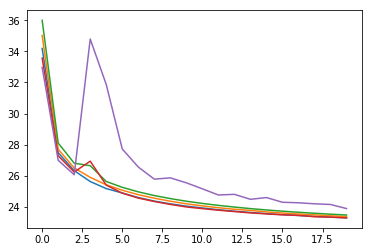

In [30]:
import math
import matplotlib.pyplot as plt
l = []
for x in list_of_files:
    with open("models/SGD/test/" + x, 'rb') as output:
            dict_emb = pickle.load(output)
    if (x!= "dict_emb_OptimSGD_momentum0_nesterovFalse_step_size1_gamma1_shuffleFalse_batch_size5000_alpha30_dim100_workers1_ctxw5_neg_samples10_use_cudaTrue_iterations20.pkl"):
        l.append([x/ 1000 for x in dict_emb['loss_list']])
    
for x in l:
    plt.plot(x)
plt.show

In [239]:
dict_emb['loss_list'] = loss_list
dict_emb['loss_list']

[18035.92383,
 18010.01367,
 17846.375,
 17360.26172,
 16836.96875,
 16446.62695,
 16132.59277,
 15858.29492,
 15618.41406,
 15411.35547,
 15234.63281,
 15081.23047,
 14946.9248,
 14827.31641,
 14719.4834,
 14621.83203,
 14532.20605,
 14448.87305,
 14371.67871,
 14300.20703]

In [240]:
# Writing embedding dictionnary to disk
with open("models/SGD/" + list_of_files[3], 'wb') as output:
    pickle.dump(dict_emb, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
subset_of_vocab = np.random.choice(te)
